In [357]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.optimize import minimize, Bounds, LinearConstraint, NonlinearConstraint

import warnings
warnings.filterwarnings('ignore')

In [358]:
alphas = []
for i in range(1, 9):
    alpha = pd.read_csv('alphas/alpha' + str(i) + '.csv', index_col='Unnamed: 0')
    profit = pd.read_csv('alphas/profit' + str(i) + '.csv', index_col='Unnamed: 0')
    alphas.append([alpha, profit])
alpha = pd.read_csv('alphas/alpha10.csv', index_col='Unnamed: 0')
profit = pd.read_csv('alphas/profit10.csv', index_col='Unnamed: 0')

In [359]:
alphas.append([alpha, profit])

In [360]:
close = pd.read_csv('Close.csv', index_col='Unnamed: 0')
returns = (close / close.shift(axis=1) - 1).dropna(axis=1)

In [361]:
def profit(alpha, returns):
    return (alpha.shift(axis=1) * returns).dropna(axis=1).sum()

def sharp(profit):
    return np.sqrt(len(profit[-252:])) * np.mean(profit) / np.std(profit)

def sharpe(profit):
    return np.sqrt(len(profit)) * np.mean(profit) / np.std(profit)

def holding_pnl(alpha):
    profit_matrix = pd.DataFrame()
    for i in range(len(alpha.columns) - 1):
        profit_matrix[alpha.columns[i + 1]] = alpha[alpha.columns[i]] * returns[alpha.columns[i + 1]]
    return profit_matrix.sum(axis=0)

def cumprofit(profit):
    return profit.cumsum()

def turnover(alpha):
    turnover_matrix = pd.DataFrame()
    for i in range(len(alpha.columns) - 1):
        turnover_matrix[alpha.columns[i + 1]] = abs(alpha[alpha.columns[i + 1]] - alpha[alpha.columns[i]])
    return turnover_matrix.sum(axis=0)

def drawdown(cumprofit):
    drawDown = 0
    maxValue = cumprofit[0]
    for i in cumprofit:
        if i > maxValue:
            maxValue = i
        else:
            if maxValue - i > drawDown:
                drawDown = maxValue - i
    return drawDown

def AlphaStats(alpha, a=0):
    if a == 1:
        plt.figure(figsize=(25,10))
        plt.title('Profit')
        plt.xlabel('Date')
        plt.ylabel('Profit')
        plt.grid()
        plt.plot(holding_pnl(alpha).cumsum())
        plt.legend(['Profit'], loc='upper left')
        plt.xticks(
            np.arange(
                -10,
                len(holding_pnl(alpha))+10,
                100
            )
        )

        plt.show()

    s = set()
    dates = []

    for i in alpha.columns[1:]:
        s.add(i[:4])
    s = list(s)
    s.sort()

    for i in s:
        dates.append([])

    for i in range(len(s)):
        for j in alpha.columns[1:]:
            if j[:4] == s[i]:
                dates[i].append(j)

    alpha_2010 = alpha[dates[0]]
    alpha_2011 = alpha[dates[1]]
    alpha_2012 = alpha[dates[2]]
    alpha_2013 = alpha[dates[3]]
    alpha_2014 = alpha[dates[4]]
    years_alphas = [alpha_2010, alpha_2011, alpha_2012, alpha_2013, alpha_2014]

    sharpes = []
    turnovers = []
    cumprofits = []
    drawdowns = []
    for i in years_alphas:
        sharpes.append(sharp(holding_pnl(i)))
        turnovers.append(turnover(i).values.mean())
        cumprofits.append(cumprofit(holding_pnl(i))[-1])
        drawdowns.append(drawdown(cumprofit(holding_pnl(i))))

    df_dict = {
        'sharpes': sharpes,
        'turnovers': turnovers,
        'cumprofits': cumprofits,
        'drawdowns': drawdowns,
        'years': s
    }

    stats = pd.DataFrame(df_dict)
    stats.set_index('years', inplace=True)
    return stats

def neutralization(alpha):
    return alpha - alpha.mean()

def normalization(alpha):
    return alpha / alpha.abs().sum()

#### Задание 1 (равные доли альф)

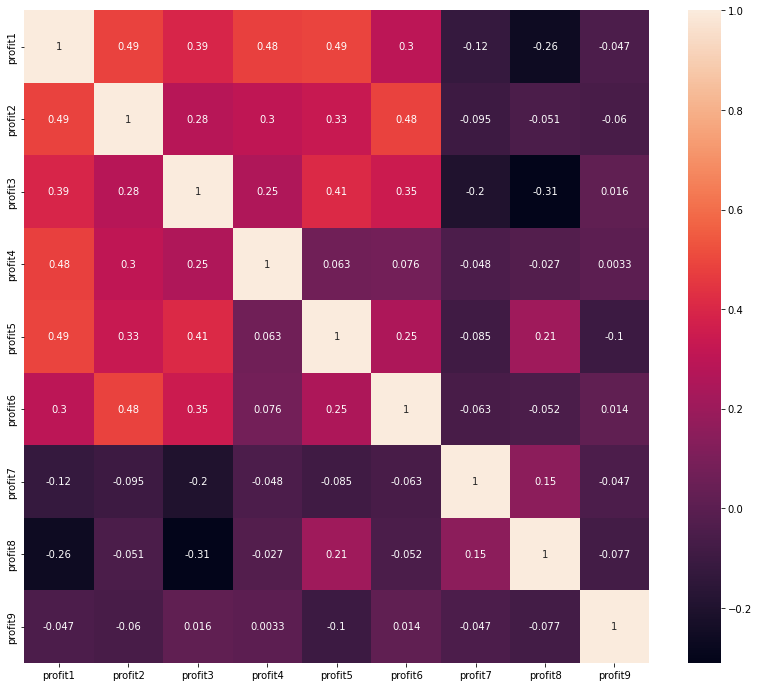

In [362]:
profits = pd.DataFrame()
for i in range(len(alphas)):
    profits['profit' + str(i + 1)] = alphas[i][1]
plt.figure(figsize = (14,12))
sns.heatmap(profits.corr(), annot=True,)
plt.show()

In [363]:
portfelProfits = pd.DataFrame()

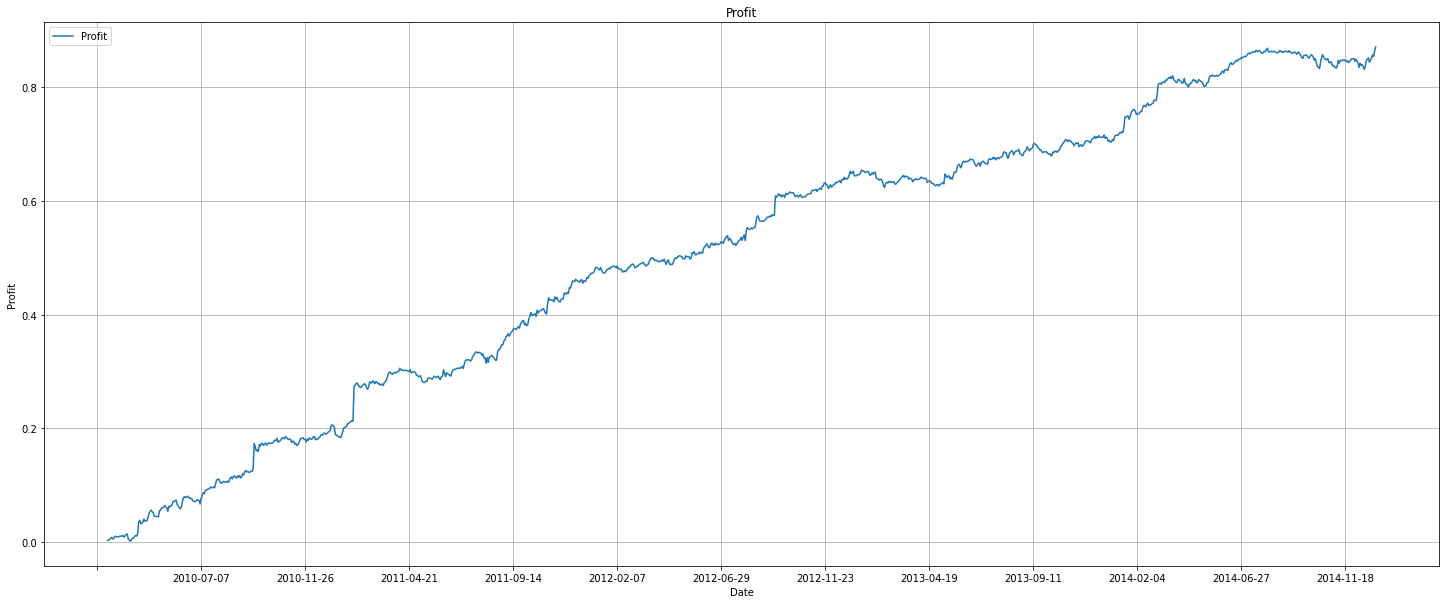

,sharpes,turnovers,cumprofits,drawdowns
years,,,,
2010,2.806772,0.521753,0.193181,0.015443
2011,3.064638,0.506238,0.267871,0.025177
2012,2.856230,0.499889,0.174781,0.017509
2013,1.073923,0.495709,0.055872,0.030844
2014,2.630228,0.492274,0.158045,0.037449


In [364]:
alpha1 = alphas[0][0][alphas[7][0].columns] * 1/9
for i in range(1, 9):
    alpha1 += alphas[i][0][alphas[7][0].columns] * 1/9
alpha1 = alpha1.apply(normalization)
portfelProfits['p1'] = profit(alpha1, returns)
AlphaStats(alpha1, 1)

In [365]:
holding_pnl(alpha1).sum()

0.8709099924434108

#### Задание 2 (веса пропорциональны Шарпу за последний год)

In [366]:
last_year_sharpe = []
last_year_profit = []
for i in range(len(alphas)):
    last_year_sharpe.append(AlphaStats(alphas[i][0])['sharpes'][-1])
    last_year_profit.append(AlphaStats(alphas[i][0])['cumprofits'][-1])

In [367]:
lyp = pd.DataFrame(last_year_profit)
lys = pd.DataFrame(last_year_sharpe)
lyp = lyp / lyp.sum()
lys = lys / lys.sum()

In [368]:
lys[0][1]

0.049048633076911874

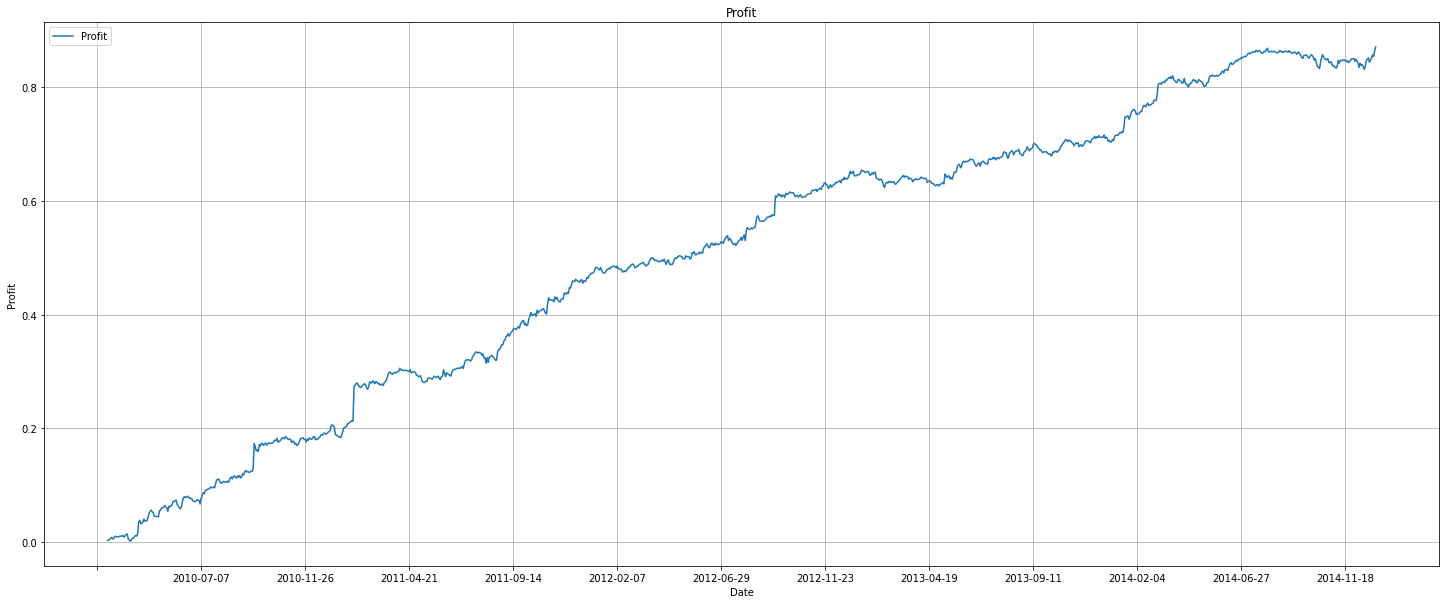

,sharpes,turnovers,cumprofits,drawdowns
years,,,,
2010,2.806772,0.521753,0.193181,0.015443
2011,3.064638,0.506238,0.267871,0.025177
2012,2.856230,0.499889,0.174781,0.017509
2013,1.073923,0.495709,0.055872,0.030844
2014,2.630228,0.492274,0.158045,0.037449


In [369]:
alpha2 = alphas[0][0][alphas[7][0].columns] * lys[0][0]
for i in range(1, 9):
    alpha2 += alphas[i][0][alphas[7][0].columns] * lys[0][i]
alpha2 = alpha2.apply(normalization)
portfelProfits['p2'] = profit(alpha2, returns)
AlphaStats(alpha1, 1)

In [370]:
holding_pnl(alpha2).sum()

0.8977125091077204

#### Задание 3 (веса пропорциональны Доходности за последний год)

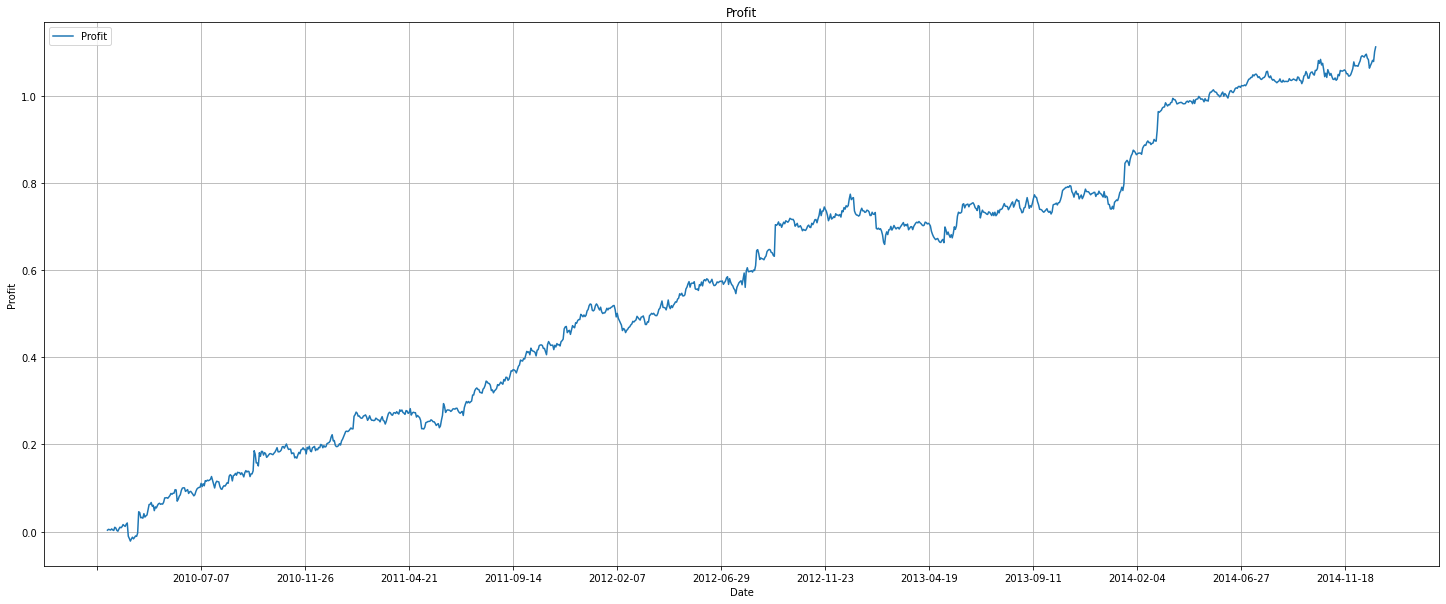

,sharpes,turnovers,cumprofits,drawdowns
years,,,,
2010,1.745479,0.450534,0.204822,0.041629
2011,2.935051,0.440012,0.304306,0.046815
2012,1.815795,0.445968,0.254133,0.065977
2013,-0.200211,0.449502,-0.024282,0.107576
2014,3.140076,0.439561,0.356934,0.047999


In [371]:
alpha3 = alphas[0][0][alphas[7][0].columns] * lyp[0][0]
for i in range(1, 9):
    alpha3 += alphas[i][0][alphas[7][0].columns] * lyp[0][i]
alpha3 = alpha3.apply(normalization)
portfelProfits['p3'] = profit(alpha3, returns)
AlphaStats(alpha3, 1)

In [372]:
holding_pnl(alpha3).sum()

1.1135153113099299

#### Задание 4 (Оптимизация Шарпа по Марковицу)

In [373]:
def f(x):
    return abs(
        1 / sharpe(
            profit(
                x[0] * alphas[0][0][alphas[7][0].columns] + \
                x[1] * alphas[1][0][alphas[7][0].columns] + \
                x[2] * alphas[2][0][alphas[7][0].columns] + \
                x[3] * alphas[3][0][alphas[7][0].columns] + \
                x[4] * alphas[4][0][alphas[7][0].columns] + \
                x[5] * alphas[5][0][alphas[7][0].columns] + \
                x[6] * alphas[6][0][alphas[7][0].columns] + \
                x[7] * alphas[7][0][alphas[7][0].columns] + \
                x[8] * alphas[8][0][alphas[7][0].columns],
                returns
            )
        )
    )

def df(x):
    return np.array([
        abs(
            1 / sharpe(
                profit(
                alphas[0][0][alphas[7][0].columns],
                returns
                )
            )
        ),
        abs(
            1 / sharpe(
                profit(
                alphas[1][0][alphas[7][0].columns],
                returns
                )
            )
        ),
        abs(
            1 / sharpe(
                profit(
                alphas[2][0][alphas[7][0].columns],
                returns
                )
            )
        ),
        abs(
            1 / sharpe(
                profit(
                alphas[3][0][alphas[7][0].columns],
                returns
                )
            )
        ),
        abs(
            1 / sharpe(
                profit(
                alphas[4][0][alphas[7][0].columns],
                returns
                )
            )
        ),
        abs(
            1 / sharpe(
                profit(
                alphas[5][0][alphas[7][0].columns],
                returns
                )
            )
        ),
        abs(
            1 / sharpe(
                profit(
                alphas[6][0][alphas[7][0].columns],
                returns
                )
            )
        ),
        abs(
            1 / sharpe(
                profit(
                alphas[7][0][alphas[7][0].columns],
                returns
                )
            )
        ),
        abs(
            1 / sharpe(
                profit(
                alphas[8][0][alphas[7][0].columns],
                returns
                )
            )
        )
    ])

lim = [-1, 1]

bounds = Bounds(
    [lim[0], lim[0], lim[0], lim[0], lim[0], lim[0], lim[0], lim[0], lim[0]],
    [lim[1], lim[1], lim[1], lim[1], lim[1], lim[1], lim[1], lim[1], lim[1]]
)

lnConstr = LinearConstraint(
    [1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1],
    [1]
)

In [374]:
res = minimize(f, [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.0], method='SLSQP', bounds=bounds, constraints=lnConstr, jac=df)
res

     fun: 0.17811737484598636
     jac: array([0.27914115, 0.46673063, 0.35349748, 0.30065966, 0.24353994,
       0.64110022, 0.39371014, 0.62494461, 0.46018287])
 message: 'Optimization terminated successfully'
    nfev: 14
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([ 0.16890315,  0.07592971,  0.13205053,  0.15823811,  0.18654789,
       -0.01047996,  0.21212026,  0.0975154 , -0.02082508])

In [375]:
a = res.x / res.x.sum()
a

array([ 0.16890315,  0.07592971,  0.13205053,  0.15823811,  0.18654789,
       -0.01047996,  0.21212026,  0.0975154 , -0.02082508])

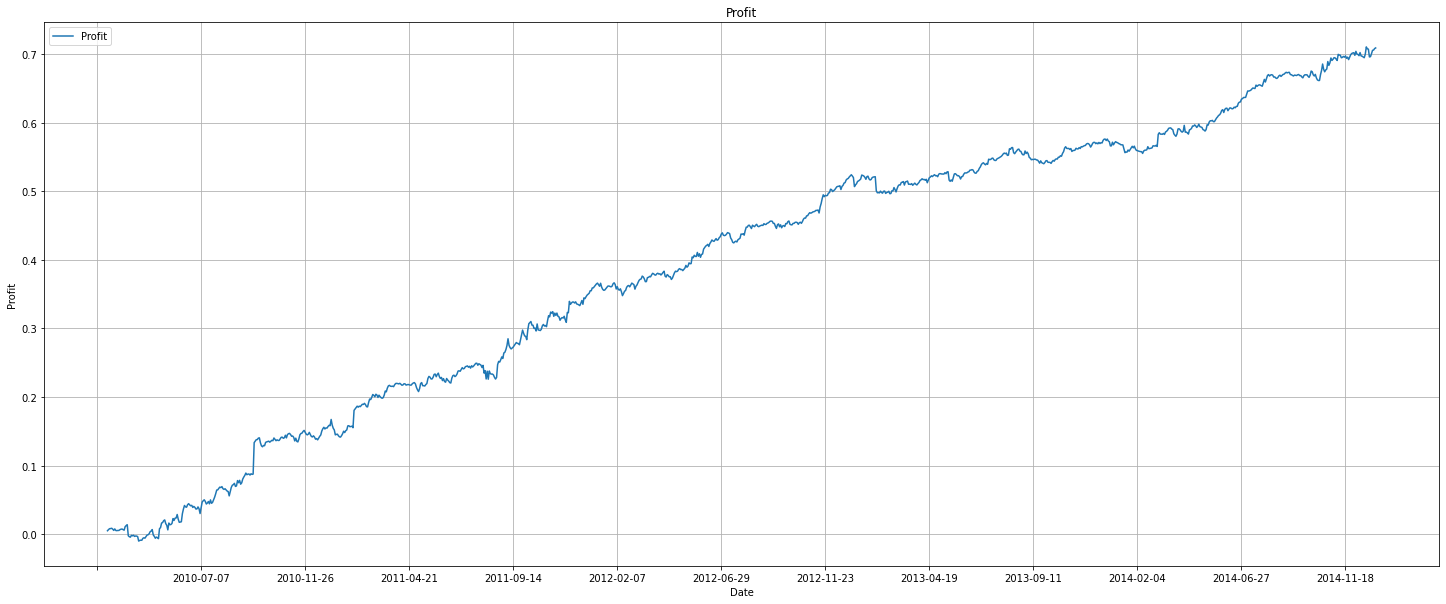

,sharpes,turnovers,cumprofits,drawdowns
years,,,,
2010,2.254560,0.600186,0.153156,0.023877
2011,2.655740,0.586751,0.187666,0.023270
2012,3.796728,0.590791,0.165017,0.018723
2013,0.988278,0.597741,0.045573,0.027106
2014,2.709121,0.592484,0.138570,0.017137


In [376]:
alpha4 = alphas[0][0][alphas[7][0].columns] * a[0]
for i in range(1, 9):
    alpha4 += alphas[i][0][alphas[7][0].columns] * a[i]
alpha4 = alpha4.apply(normalization)
portfelProfits['p4'] = profit(alpha4, returns)
AlphaStats(alpha4, 1)

In [377]:
holding_pnl(alpha4).sum()

0.7089113115968563

In [378]:
sharpe(holding_pnl(alpha4))

5.534373253893974

#### Задание 5 (Назначение рисков)

In [379]:
for i in alphas:
    print(profit(i[0], returns).cumsum()[-1])

0.4605090026422434
0.45598267839324835
0.5025531306210311
0.4914775055454578
0.4122446682393104
0.3944092390941694
0.6119860380957586
0.5431004920480772
1.1171276310868783


In [380]:
a = profits.dropna().cov()
w = pd.DataFrame([1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9])
x = pd.DataFrame([0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.075, 0.4])

def f(w):
    return pd.DataFrame(w).T.dot(a.values).dot(pd.DataFrame(w))[0][0] / 2 \
    - x[0][0]*np.log(pd.DataFrame(w)[0][0]) \
    - x[0][1]*np.log(pd.DataFrame(w)[0][1]) \
    - x[0][2]*np.log(pd.DataFrame(w)[0][2]) \
    - x[0][3]*np.log(pd.DataFrame(w)[0][3]) \
    - x[0][4]*np.log(pd.DataFrame(w)[0][4]) \
    - x[0][5]*np.log(pd.DataFrame(w)[0][5]) \
    - x[0][6]*np.log(pd.DataFrame(w)[0][6]) \
    - x[0][7]*np.log(pd.DataFrame(w)[0][7]) \
    - x[0][8]*np.log(pd.DataFrame(w)[0][8])


def df(w):
    return a.values.dot(np.array(w)) - np.array([
        x[0][0] * 1 / pd.DataFrame(w)[0][0],
        x[0][1] * 1 / pd.DataFrame(w)[0][0],
        x[0][2] * 1 / pd.DataFrame(w)[0][0],
        x[0][3] * 1 / pd.DataFrame(w)[0][0],
        x[0][4] * 1 / pd.DataFrame(w)[0][0],
        x[0][5] * 1 / pd.DataFrame(w)[0][0],
        x[0][6] * 1 / pd.DataFrame(w)[0][0],
        x[0][7] * 1 / pd.DataFrame(w)[0][0],
        x[0][8] * 1 / pd.DataFrame(w)[0][0]
    ])[0]

def ddf(w):
    return a.values + np.diag((x * 1/w**2).T.values[0])

bounds = Bounds(
        [lim[0], lim[0], lim[0], lim[0], lim[0], lim[0], lim[0], lim[0], lim[0]],
        [lim[1], lim[1], lim[1], lim[1], lim[1], lim[1], lim[1], lim[1], lim[1]]
)

lnConstr = LinearConstraint(
        [1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1],
        [1]
)

In [381]:
res3 = minimize(f, [1/9, 1/9, 1/9, 5/9, 1/9, 1/9, 1/9, 3/9, 2/9], method='SLSQP', bounds=bounds, constraints=lnConstr, jac=df, hess=ddf)
c = res3.x
res3

     fun: 2.2428760733756365
     jac: array([-1.05909208, -1.05057845, -1.0488617 , -1.0361918 , -1.0324714 ,
       -1.03873699, -1.03881533, -1.05315814, -1.0453475 ])
 message: 'Optimization terminated successfully'
    nfev: 18
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.06270371, 0.04103933, 0.14574025, 0.08725968, 0.03190667,
       0.07239769, 0.18896974, 0.19123236, 0.17875057])

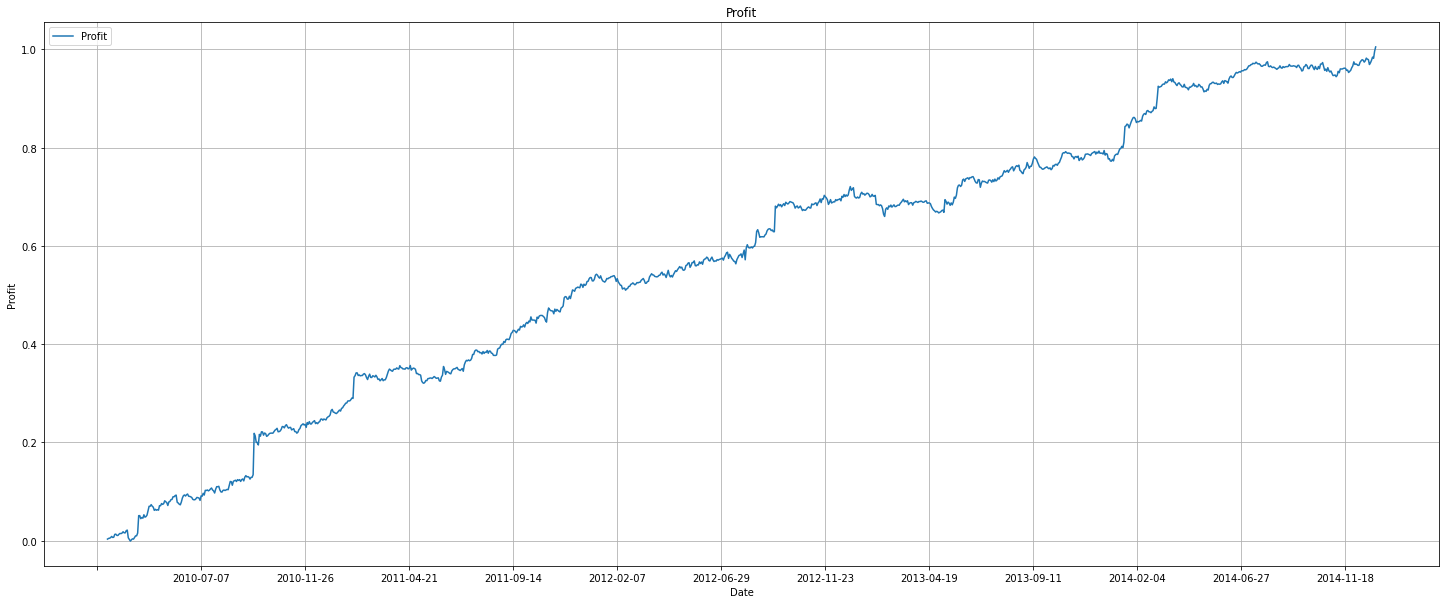

,sharpes,turnovers,cumprofits,drawdowns
years,,,,
2010,2.300245,0.492184,0.252789,0.023658
2011,3.358150,0.466472,0.270389,0.036238
2012,2.023072,0.460411,0.184091,0.032520
2013,0.769062,0.455615,0.057161,0.058447
2014,2.999868,0.447828,0.221933,0.030493


In [382]:
alpha5 = alphas[0][0][alphas[7][0].columns] * c[0]
for i in range(1, 9):
    alpha5 += alphas[i][0][alphas[7][0].columns] * c[i]
alpha5 = alpha5.apply(normalization)
portfelProfits['p5'] = profit(alpha5, returns)
AlphaStats(alpha5, 1)